<a href="https://colab.research.google.com/github/deansaco/Traffic_Sign_Classifier/blob/main/GoogLeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q -U keras_tuner

     |████████████████████████████████| 98 kB 3.1 MB/s 


In [2]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np
from glob import glob
import os
import pickle
import math
import random
import csv
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle


print('All modules imported.')

All modules imported.


In [3]:
#mount zip file for google colab gpu use
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

# Location of Zip File
drive_path = '/gdrive/MyDrive/Traffic-Sign-Classifier-master.zip'
local_path = '/content'

# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .

# Navigate to the copied file and unzip it quietly
os.chdir(local_path)
!unzip -qq 'Traffic-Sign-Classifier-master.zip'

Mounted at /gdrive


# 1 Reload the preprocessed data

In [61]:
# 1 Reload the preprocessed data

pickle_file = '/content/Traffic-Sign-Classifier-master/traffic-signs-data/pre-data.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_features']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_features']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_features']
    y_test = pickle_data['test_labels']
    signnames = pickle_data['signnames']
    del pickle_data  # Free up memory


In [64]:
# #convert output into one hot encoded vector
y_train = tf.one_hot(y_train, 43)
y_valid = tf.one_hot(y_valid, 43)
y_test = tf.one_hot(y_test, 43)


# Model Architecture

## Inception Block and GoogleNet

In [87]:

def create_googlenet(input_shape, n_classes):
      
      def inception_block(x, f):
          
          t1 = Conv2D(f[0], 1, activation='relu')(x)

          t2 = Conv2D(f[1], 1, activation='relu')(x)
          t2 = Conv2D(f[2], 3, padding='same', activation='relu')(t2)

          t3 = Conv2D(f[3], 1, activation='relu')(x)
          t3 = Conv2D(f[4], 5, padding='same', activation='relu')(t3)

          t4 = MaxPool2D(3, 1, padding='same')(x)
          t4 = Conv2D(f[5], 1, activation='relu')(t4)

          output = Concatenate()([t1, t2, t3, t4])
          return output
      
      input = Input(input_shape) #this is the input to the function
    
      #x = Conv2D(64, 7, strides=2, padding='same', activation='relu')(input)
      #x = MaxPool2D(3, strides=2, padding='same')(x)
    
      #x = Conv2D(64, 1, activation='relu')(input)
      #x = Conv2D(192, 3, padding='same', activation='relu')(input)
      #x = MaxPool2D(3, strides=2)(x)

      
     
      
      x = Conv2D(64, 3, strides=2, activation='relu')(input)
      x = inception_block(x, [64, 96, 128, 16, 32, 32])
      x = inception_block(x, [128, 128, 192, 32, 96, 64])
      x = MaxPool2D(3, padding='same')(x)

      x = inception_block(x, [192, 96, 208, 16, 48, 64])
      x = inception_block(x, [160, 112, 224, 24, 64, 64])
      x = MaxPool2D(3, padding='same')(x)

      x = inception_block(x, [256, 160, 320, 32, 128, 128])
      x = inception_block(x, [384, 192, 384, 48, 128, 128])
      x = MaxPool2D(3, strides=1, padding='same')(x)

      x = inception_block(x, [128, 128, 256, 24, 64, 64])
      x = inception_block(x, [112, 144, 288, 32, 64, 64])
      x = inception_block(x, [256, 160, 320, 32, 128, 128])
      x = MaxPool2D(3, strides=2, padding='same')(x)

      x = Dropout(0.5)(x)

      x = Flatten()(x)
      output = Dense(n_classes, activation='softmax')(x) #this is the output

      model = Model(input, output)
      
      LEARNING_RATE=4e-4
      
      
      opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, name='Adam')
      loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
      model.compile(optimizer=opt,loss=loss_function, metrics=['acc'])
      
      return model


In [ ]:
input_shape=(32,32,3)
n_classes=43
googlenet=create_googlenet(input_shape, n_classes)

In [92]:
history = googlenet.fit(X_train, y_train, 
                         epochs=30, 
                         batch_size=128,
                         validation_data=(X_test, y_test))

Epoch 1/30
272/272 [==============================] - 49s 180ms/step - loss: 0.0169 - acc: 0.9968 - val_loss: 0.2409 - val_acc: 0.9549
Epoch 2/30
272/272 [==============================] - 49s 180ms/step - loss: 0.0096 - acc: 0.9981 - val_loss: 0.1601 - val_acc: 0.9675
Epoch 3/30
272/272 [==============================] - 49s 179ms/step - loss: 0.0199 - acc: 0.9965 - val_loss: 0.3238 - val_acc: 0.9546
Epoch 4/30
272/272 [==============================] - 49s 180ms/step - loss: 0.0242 - acc: 0.9955 - val_loss: 0.2504 - val_acc: 0.9612
Epoch 5/30
272/272 [==============================] - 49s 180ms/step - loss: 0.0190 - acc: 0.9963 - val_loss: 0.1662 - val_acc: 0.9690
Epoch 6/30
272/272 [==============================] - 49s 180ms/step - loss: 0.0012 - acc: 0.9996 - val_loss: 0.1878 - val_acc: 0.9729
Epoch 7/30
272/272 [==============================] - 49s 180ms/step - loss: 0.0012 - acc: 0.9997 - val_loss: 0.2171 - val_acc: 0.9663
Epoch 8/30
272/272 [==============================] - 5

# 3 Training

395/395 - 7s - loss: 0.2480 - acc: 0.9584 - 7s/epoch - 19ms/step
Test Accuracy: 95.83531022071838


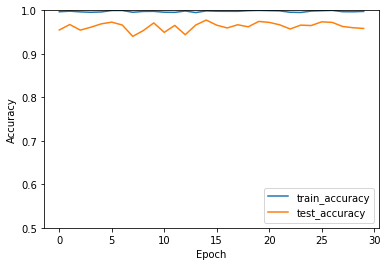

In [93]:
plt.plot(history.history['acc'], label='train_accuracy')
plt.plot(history.history['val_acc'], label = 'test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#evaluate model
test_loss, test_accuracy = googlenet.evaluate(X_test, y_test, verbose=2)

      
print(f'Test Accuracy:', 100*test_accuracy)

In [94]:
test_loss, test_accuracy = googlenet.evaluate(X_test, y_test)
valid_loss, valid_accuracy = googlenet.evaluate(X_valid, y_valid)
train_loss, train_accuracy =googlenet.evaluate(X_train, y_train)


print("restored model, test accuracy: {:5.2f}%".format(100*test_accuracy))
print("restored model, validation accuracy: {:5.2f}%".format(100*valid_accuracy))

print("restored model, train accuracy: {:5.2f}%".format(100*train_accuracy))

1088/1088 [==============================] - 25s 23ms/step - loss: 0.0104 - acc: 0.9977
restored model, test accuracy: 95.84%
restored model, validation accuracy: 97.46%
restored model, train accuracy: 99.77%


predicted sign: Speed limit (30km/h)


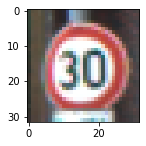

real sign: Speed limit (30km/h)




predicted sign: Keep right


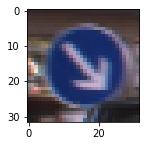

real sign: Keep right




predicted sign: Turn right ahead


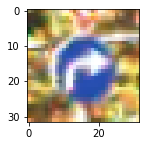

real sign: Turn right ahead




predicted sign: Right-of-way at the next intersection


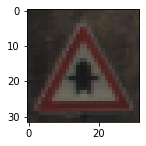

real sign: Right-of-way at the next intersection




predicted sign: Keep right


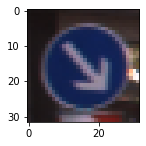

real sign: Keep right




predicted sign: General caution


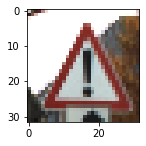

real sign: General caution




predicted sign: Priority road


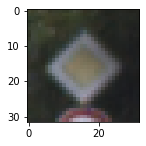

real sign: Priority road




predicted sign: Road work


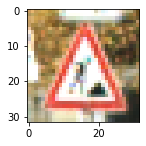

real sign: Road work




predicted sign: Ahead only


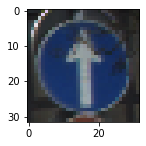

real sign: Ahead only






In [95]:
for i in range(1,10):
    test_image = X_test[i]
    array=np.expand_dims(test_image, axis=0)
    prediction = googlenet.predict(array)
    prediction= (np.argmax(prediction))
    print("predicted sign:", signnames[prediction])    
    test_label= y_test[i]
    arr=np.expand_dims(test_label, axis=0)
    truth= (np.argmax(arr))
    plt.figure(figsize=(12,12))
    # define subplot
    plt.subplot(5, 5, i+1)
    # plot raw pixel data
    plt.imshow(test_image, cmap=plt.get_cmap('gray'))
    # show the figure
    plt.show()
    print("real sign:", signnames[truth])
    print('\n')
    print('\n')